# Feature Engineering from Just Latitude and Longitude

The purpose of this notebook is to demonstrate a few feature engineering techniques that use only latitude and longitude.

It compares these feature engineering techniques by using them on a prediction problem from Kaggle, "Predicting Airbnb Prices" ([dataset](https://www.kaggle.com/datasets/kritikseth/us-airbnb-open-data)).

Tools used include `polars`, `numpy`, `matplotlib`, `xgboost`, `scikit-learn`, and `scipy`.

## 0. Env

In [14]:
import os
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, rmse
import geohash2
from scipy import spatial
import plotly.graph_objects as go
import plotly.express as px

ImportError: cannot import name 'rmse' from 'sklearn.metrics' (/Users/ben/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/metrics/__init__.py)

In [2]:
home = "../.."
images_dir = os.path.join(home, "static/images/")

In [3]:
TRAIN_TEST_SPLIT_FRACTION = 0.8
MODEL_TARGET = "price_log10"
GEOHASH_PRECISION = 6

## 1. Load Data

#### Choosing a target city for the problem... which city has the most data?

In [4]:
(
    pl.read_csv("../data/AB_US_2023.csv")
    ["city"]
    .value_counts()
    .sort(by="counts", descending=True)
    .head(5)
)

city,counts
str,u32
"""New York City""",42931
"""Los Angeles""",42451
"""Broward County…",16899
"""Austin""",14368
"""Clark County""",13933


#### Load data for New York City

In [5]:
df_query = (
    pl.scan_csv("../data/AB_US_2023.csv")
    .filter(pl.col("city") == "New York City")
    .select(pl.col(["latitude", "longitude", "price"]))
    .with_columns((pl.col("price") + 1).log10().suffix("_log10"))
)

In [6]:
num_rows = df_query.collect().shape[0]
df = (
    df_query.collect()
    .sample(fraction=1, shuffle=True)
    .with_row_count(name="row_number")
    .with_columns([
        (pl.col("row_number") < TRAIN_TEST_SPLIT_FRACTION * num_rows).alias("is_train")
    ])
)

#### Viewing the data

In [7]:
display(
    df
    .head()
)

row_number,latitude,longitude,price,price_log10,is_train
u32,f64,f64,i64,f64,bool
0,40.71813,-73.95826,400,2.603144,true
1,40.65233,-73.91676,130,2.117271,true
2,40.77348,-73.95482,247,2.394452,true
3,40.66179,-73.8671,125,2.100371,true
4,40.71652,-73.94204,800,2.903633,true


## 2. Brief EDA

#### Distribution of Prices

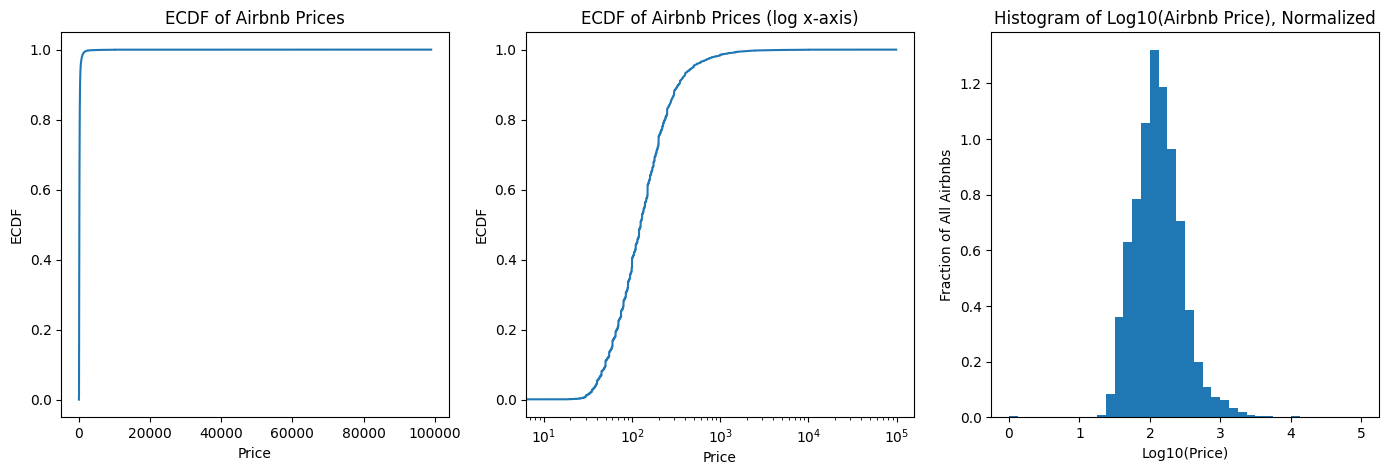

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax1.set_xlabel("Price")
ax1.set_ylabel("ECDF")
ax1.set_title("ECDF of Airbnb Prices")

ax2.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax2.set_xscale("log")
ax2.set_xlabel("Price")
ax2.set_ylabel("ECDF")
ax2.set_title("ECDF of Airbnb Prices (log x-axis)")

ax3.hist(df["price_log10"], bins=40, density=True)
ax3.set_xlabel("Log10(Price)")
ax3.set_ylabel("Fraction of All Airbnbs")
ax3.set_title("Histogram of Log10(Airbnb Price), Normalized")

plt.savefig("../../static/images/distribution-of-airbnb-price.png")

#### Distribution over Space

In [9]:
df_sample = df.sample(fraction=.2, shuffle=True)
fig = px.scatter_mapbox(
    data_frame=df_sample,
    lat="latitude",
    lon="longitude",
    color="price_log10",
    range_color=[1, 5]
)
fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r":0, "t":0, "l":0, "b":0},
    mapbox_bounds={
        "west": -74.108,
        "east": -73.763,
        "south": 40.565,
        "north": 40.886,
    },
    coloraxis_colorbar={
        "title": "Airbnb Price",
        "tickvals": [0, 1, 2, 3, 4, 5, 6],
        "ticktext": ["$1", "$10", "$100", "$1K", "$10K", "$100K"]
    },
)
fig.write_image(os.path.join(images_dir, "nyc-airbnb-prices.png"))

In [10]:
df.select(["latitude", "longitude", "price"]).corr()

latitude,longitude,price
f64,f64,f64
1.0,0.046993,0.008133
0.046993,1.0,-0.058381
0.008133,-0.058381,1.0


### 1.1 Raw Latitude and Longitude

In [17]:
MODEL_FEATURE_LIST_NAME = "raw_lat_lon"
MODEL_FEATURE_LIST = ["latitude", "longitude"]

X_train = df.filter(pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_train = df.filter(pl.col("is_train")).select(MODEL_TARGET)
X_test = df.filter(~pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_test = df.filter(~pl.col("is_train")).select(MODEL_TARGET).to_numpy()

model_performance_list = []
for model_name, model_class in zip(
    ["xgboost", "ridge regression"],
    [XGBRegressor, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    model_performance = mean_squared_error(y_test, y_predicted, squared=False)
    model_performance_list.append({
        "feature_list_name": MODEL_FEATURE_LIST_NAME,
        "model_name": model_name,
        "model_performance": model_performance
    })
    df.with_columns()

raw_lat_lon_results_df = (
    pd.DataFrame
    .from_records(model_performance_list)
    .pivot_table(
        index="feature_list_name",
        columns="model_name",
        values="model_performance",
        aggfunc="first"
    )
)
raw_lat_lon_results_df.index.name = None
raw_lat_lon_results_df.columns.name = None
raw_lat_lon_results_df = 10 ** raw_lat_lon_results_df

print(
    raw_lat_lon_results_df
    .style
    .format("${:.2f}")
    .background_gradient(vmin=0, vmax=1)
    .to_html()
)

<style type="text/css">
#T_09dff_row0_col0, #T_09dff_row0_col1 {
  background-color: #023858;
  color: #f1f1f1;
}
</style>
<table id="T_09dff">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_09dff_level0_col0" class="col_heading level0 col0" >ridge regression</th>
      <th id="T_09dff_level0_col1" class="col_heading level0 col1" >xgboost</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_09dff_level0_row0" class="row_heading level0 row0" >raw_lat_lon</th>
      <td id="T_09dff_row0_col0" class="data row0 col0" >$2.13</td>
      <td id="T_09dff_row0_col1" class="data row0 col1" >$1.98</td>
    </tr>
  </tbody>
</table>



### 1.2 Neighborhood Density

In [18]:
def add_density_feature_columns_to_dataframe(geo_df: pl.DataFrame) -> pl.DataFrame:
    tree = spatial.cKDTree(df.select(["latitude", "longitude"]))
    result = geo_df.with_columns(
        pl.Series(
            "spatial_density",
            tree.query_ball_point(geo_df.select(["latitude", "longitude"]), .02, return_length=True)
        )
    )
    return result

In [20]:
df_w_density = add_density_feature_columns_to_dataframe(df)

MODEL_FEATURE_LIST_NAME = "spatial_density"
MODEL_FEATURE_LIST = ["spatial_density"]

X_train = df_w_density.filter(pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_train = df_w_density.filter(pl.col("is_train")).select(MODEL_TARGET)
X_test = df_w_density.filter(~pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_test = df_w_density.filter(~pl.col("is_train")).select(MODEL_TARGET).to_numpy()

model_performance_list = []
for model_name, model_class in zip(
    ["xgboost", "ridge regression"],
    [XGBRegressor, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    model_performance = mean_squared_error(y_test, y_predicted)
    model_performance_list.append({
        "feature_list_name": MODEL_FEATURE_LIST_NAME,
        "model_name": model_name,
        "model_performance": model_performance
    })

spatial_density_results_df = (
    pd.DataFrame
    .from_records(model_performance_list)
    .pivot_table(
        index="feature_list_name",
        columns="model_name",
        values="model_performance",
        aggfunc="first"
    )
)
spatial_density_results_df.index.name = None
spatial_density_results_df.columns.name = None
spatial_density_results_df = 10 ** spatial_density_results_df

print(
    pd.concat([raw_lat_lon_results_df, spatial_density_results_df])
    .style
    .format("{:.3f}")
    .background_gradient(vmin=0, vmax=1)
    .to_html()
)

<style type="text/css">
#T_55b6c_row0_col0, #T_55b6c_row0_col1, #T_55b6c_row1_col0, #T_55b6c_row1_col1 {
  background-color: #023858;
  color: #f1f1f1;
}
</style>
<table id="T_55b6c">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_55b6c_level0_col0" class="col_heading level0 col0" >ridge regression</th>
      <th id="T_55b6c_level0_col1" class="col_heading level0 col1" >xgboost</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_55b6c_level0_row0" class="row_heading level0 row0" >raw_lat_lon</th>
      <td id="T_55b6c_row0_col0" class="data row0 col0" >2.130</td>
      <td id="T_55b6c_row0_col1" class="data row0 col1" >1.977</td>
    </tr>
    <tr>
      <th id="T_55b6c_level0_row1" class="row_heading level0 row1" >spatial_density</th>
      <td id="T_55b6c_row1_col0" class="data row1 col0" >1.280</td>
      <td id="T_55b6c_row1_col1" class="data row1 col1" >1.273</td>
    </tr>
  </tbody>
</table>



### 1.3 Geohash category

In [16]:
def add_geohash_category_column_to_dataframe(geo_df: pl.DataFrame, geohash_precision=6) -> pl.DataFrame:
    geo_df = (
        geo_df
        .with_columns(
            geo_df
            .select(["latitude", "longitude"])
            .apply(
                lambda x: geohash2.encode(x[0], x[1], precision=geohash_precision)
            )
            .rename({"apply": "geohash"})
        )
    )
    return geo_df

In [17]:
def add_geohash_one_hot_encoded_category_columns_to_dataframe(
    geo_df: pl.DataFrame,
    geohash_precision=6
) -> pl.DataFrame:
    result = (
        add_geohash_category_column_to_dataframe(
            geo_df,
            geohash_precision=geohash_precision
        )
        .to_dummies(columns="geohash")
    )
    return result

In [25]:
df_w_geohash_ohe = add_geohash_one_hot_encoded_category_columns_to_dataframe(df)
display(df_w_geohash_ohe.head())
display(df_w_geohash_ohe.filter(pl.col("is_train")).head())

MODEL_FEATURE_PATTERN = "^geohash_.*$"

X_train = df_w_geohash_ohe.filter(pl.col("is_train")).select(pl.col(MODEL_FEATURE_PATTERN))
y_train = df_w_geohash_ohe.filter(pl.col("is_train")).select(MODEL_TARGET)
X_test = df_w_geohash_ohe.filter(~pl.col("is_train")).select(pl.col(MODEL_FEATURE_PATTERN))
y_test = df_w_geohash_ohe.filter(~pl.col("is_train")).select(MODEL_TARGET).to_numpy()

for model_name, model_class in zip(
    ["xgboost", "ridge regression"],
    [XGBRegressor, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    print(f"{model_name}, {mean_squared_error(y_test, y_predicted):.7f} (sklearn)")

geohash_categorical_results_df = (
    pd.DataFrame
    .from_records(model_performance_list)
    .pivot_table(
        index="feature_list_name",
        columns="model_name",
        values="model_performance",
        aggfunc="first"
    )
)

display(
    pd.concat([
        raw_lat_lon_results_df,
        spatial_density_results_df,
        geohash_categorical_results_df
    ])
    .style
    .format("{:.3f}")
    .background_gradient(vmin=0, vmax=1)
    .to_html()
)

row_number,latitude,longitude,price,price_log1p,is_train,geohash_dr5nqm,geohash_dr5nqq,geohash_dr5nqs,geohash_dr5nqw,geohash_dr5nx1,geohash_dr5nx2,geohash_dr5nx3,geohash_dr5nx7,geohash_dr5nxd,geohash_dr5nxm,geohash_dr5nxq,geohash_dr5nxt,geohash_dr5nxv,geohash_dr5nxw,geohash_dr5nzb,geohash_dr5nzv,geohash_dr5nzy,geohash_dr5q85,geohash_dr5q8e,geohash_dr5q8g,geohash_dr5q8j,geohash_dr5q8k,geohash_dr5q8m,geohash_dr5q8r,geohash_dr5q8s,geohash_dr5q8t,geohash_dr5q8u,geohash_dr5q8v,geohash_dr5q8z,geohash_dr5q9p,geohash_dr5q9r,…,geohash_dr72xf,geohash_dr72xg,geohash_dr72xj,geohash_dr72xk,geohash_dr72xm,geohash_dr72xq,geohash_dr72xs,geohash_dr72xt,geohash_dr72xu,geohash_dr72xw,geohash_dr7800,geohash_dr7802,geohash_dr7805,geohash_dr7808,geohash_dr780j,geohash_dr780n,geohash_dr780p,geohash_dr780q,geohash_dr780r,geohash_dr780t,geohash_dr7810,geohash_dr7811,geohash_dr7820,geohash_dr7821,geohash_dr7822,geohash_dr7823,geohash_dr7824,geohash_dr7825,geohash_dr7827,geohash_dr782g,geohash_dr782p,geohash_dr782u,geohash_dr782v,geohash_dr7834,geohash_dr7880,geohash_dr7885,geohash_dr7887
u32,f64,f64,i64,f64,bool,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
0,40.75356,-73.98559,150,5.01728,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40.68535,-73.95512,60,4.110874,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40.8038,-73.96751,75,4.330733,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40.76457,-73.98317,68,4.234107,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,40.66265,-73.99454,275,5.620401,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


row_number,latitude,longitude,price,price_log1p,is_train,geohash_dr5nqm,geohash_dr5nqq,geohash_dr5nqs,geohash_dr5nqw,geohash_dr5nx1,geohash_dr5nx2,geohash_dr5nx3,geohash_dr5nx7,geohash_dr5nxd,geohash_dr5nxm,geohash_dr5nxq,geohash_dr5nxt,geohash_dr5nxv,geohash_dr5nxw,geohash_dr5nzb,geohash_dr5nzv,geohash_dr5nzy,geohash_dr5q85,geohash_dr5q8e,geohash_dr5q8g,geohash_dr5q8j,geohash_dr5q8k,geohash_dr5q8m,geohash_dr5q8r,geohash_dr5q8s,geohash_dr5q8t,geohash_dr5q8u,geohash_dr5q8v,geohash_dr5q8z,geohash_dr5q9p,geohash_dr5q9r,…,geohash_dr72xf,geohash_dr72xg,geohash_dr72xj,geohash_dr72xk,geohash_dr72xm,geohash_dr72xq,geohash_dr72xs,geohash_dr72xt,geohash_dr72xu,geohash_dr72xw,geohash_dr7800,geohash_dr7802,geohash_dr7805,geohash_dr7808,geohash_dr780j,geohash_dr780n,geohash_dr780p,geohash_dr780q,geohash_dr780r,geohash_dr780t,geohash_dr7810,geohash_dr7811,geohash_dr7820,geohash_dr7821,geohash_dr7822,geohash_dr7823,geohash_dr7824,geohash_dr7825,geohash_dr7827,geohash_dr782g,geohash_dr782p,geohash_dr782u,geohash_dr782v,geohash_dr7834,geohash_dr7880,geohash_dr7885,geohash_dr7887
u32,f64,f64,i64,f64,bool,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
0,40.75356,-73.98559,150,5.01728,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40.68535,-73.95512,60,4.110874,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40.8038,-73.96751,75,4.330733,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40.76457,-73.98317,68,4.234107,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,40.66265,-73.99454,275,5.620401,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


xgboost, 0.5920653 (sklearn)
ridge regression, 0.5640281 (sklearn)


KeyError: '`Styler.apply` and `.applymap` are not compatible with non-unique index or columns.'

### 1.4 Geohash Target Encoding

In [ ]:
df = (
    df
    .join(
        df
        .filter(pl.col("is_train"))
        .groupby(f"geohash_{geohash_precision}")
        .agg([
            pl.col("price").median().alias("geohash_price_median"),
            pl.col("price").max().alias("geohash_price_max"),
        ]),
        on=f"geohash_{geohash_precision}",
        how="left"
    )
    .join(
        df
        # .filter(pl.col("is_train"))
        .groupby(f"geohash_{geohash_precision}")
        .agg([
            pl.col("price").count().alias("geohash_price_count"),
        ]),
        on=f"geohash_{geohash_precision}",
        how="left"
    )
)

In [ ]:
MODEL_FEATURE_LIST = [
    "geohash_price_count",
    "geohash_price_median",
    "geohash_price_max",
]

X_train = df.filter(pl.col("is_train") & pl.col("geohash_price_max").is_not_null()).select(MODEL_FEATURE_LIST)
y_train = df.filter(pl.col("is_train") & pl.col("geohash_price_max").is_not_null()).select(MODEL_TARGET)
X_test = df.filter(~pl.col("is_train") & pl.col("geohash_price_max").is_not_null()).select(MODEL_FEATURE_LIST)
y_test = df.filter(~pl.col("is_train") & pl.col("geohash_price_max").is_not_null()).select(MODEL_TARGET).to_numpy()

for model_name, model_class in zip(
    ["xgboost", "linear regression", "ridge regression"],
    [XGBRegressor, LinearRegression, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    print(f"{model_name}, {mean_squared_error(y_test, y_predicted):.7f} (sklearn)")